In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow.keras.applications as keras_apps
import cryptovision.tools as tools
from tensorflow.keras import layers

2025-02-08 18:07:49.237 | INFO     | cryptovision.config:<module>:15 - PROJ_ROOT path is: /Users/leonardo/Documents/Projects/cryptovision


In [16]:
df = pd.read_csv(
    '/Volumes/T7_shield/CryptoVision/Data/Images/Datasets/v3.0.0/image_catalog_clean.csv'
)

SEED = 42
image_size = (128, 128)
level = 'species'
epochs = 20

def clean_dataframe(df, sample_limit):
    # Rmv duplicates
    df = df.drop_duplicates(subset='hash', keep='first')

    # Rmv Species with less than few images
    df = df[df['species'].map(df['species'].value_counts()) > sample_limit]
    
    df.reset_index(drop=True, inplace=True)
    
    return df

df = clean_dataframe(df, 50)

train_df, val_df, test_df = tools.split_dataframe(
    df,
    test_size=0.15,
    val_size=0.15,
    stratify_by='folder_label',
    random_state=SEED,
)

train_ds = tools.tensorflow_dataset(
    train_df,
    batch_size=128,
    image_size=(128, 128),
)

val_ds = tools.tensorflow_dataset(
    val_df,
    batch_size=128,
    image_size=(128, 128),
)

test_ds = tools.tensorflow_dataset(
    test_df,
    batch_size=128,
    image_size=image_size,
)

train_datasets = {
    'all': train_ds,
    'family': train_ds.map(lambda image, labels: (image, labels['family'])),
    'genus': train_ds.map(lambda image, labels: (image, labels['genus'])),
    'species': train_ds.map(lambda image, labels: (image, labels['species'])),
}

val_datasets = {
    'all': val_ds,
    'family': val_ds.map(lambda image, labels: (image, labels['family'])),
    'genus': val_ds.map(lambda image, labels: (image, labels['genus'])),
    'species': val_ds.map(lambda image, labels: (image, labels['species'])),
}

test_datasets = {
    'all': test_ds,
    'family': test_ds.map(lambda image, labels: (image, labels['family'])),
    'genus': test_ds.map(lambda image, labels: (image, labels['genus'])),
    'species': test_ds.map(lambda image, labels: (image, labels['species'])),
}

In [18]:
df_v1 = pd.read_csv(
    '/Volumes/T7_shield/CryptoVision/Data/Images/Datasets/v1.0.0/images_catalog.csv'
)

v1_sp_list = df_v1['species'].unique()

v3_sp_list = df['species'].unique()

df[df['species'].isin(v1_sp_list)]['species'].value_counts()

species
Nemateleotris magnifica          905
Pseudocheilinus hexataenia       733
Canthigaster solandri            727
Istigobius decoratus             702
Corythoichthys flavofasciatus    624
Chaetodon quadrimaculatus        620
Chromis margaritifer             559
Pomacanthus maculosus            555
Pomacentrus pavo                 523
Acanthemblemaria aspera          523
Eviota albolineata               473
Labroides dimidiatus             421
Koumansetta rainfordi            383
Eviota melasma                   380
Cypho purpurascens               378
Paracirrhites arcatus            357
Fusigobius neophytus             356
Eviota atriventris               350
Pomacentrus amboinensis          350
Centropyge bispinosa             346
Ostorhinchus angustatus          326
Doryrhamphus excisus             320
Gomphosus varius                 319
Cirripectes variolosus           312
Apogon maculatus                 302
Trimma macrophthalmus            296
Centropyge flavissima         

In [3]:
print(f"Train size: {len(train_df)} | Validation size: {len(val_df)} | Test size: {len(test_df)}")
print(f"Classes sizes - Fam: {df['family'].nunique()} | Gen: {df['genus'].nunique()} | Spe: {df['species'].nunique()}")

Train size: 19156 | Validation size: 4106 | Test size: 4106
Classes sizes - Fam: 21 | Gen: 56 | Spe: 104


In [4]:
# Build Model

# Augmentation
augmentation = tf.keras.Sequential(
    [
        layers.RandomFlip("horizontal", seed=SEED),
        layers.RandomRotation(0.1, seed=SEED),
        layers.RandomZoom(height_factor=(0.05, 0.1), width_factor=(0.05, 0.1), seed=SEED),  # Wider zoom range
        layers.RandomContrast(0.2, seed=SEED),
        layers.RandomBrightness(0.2, seed=SEED),
        layers.RandomTranslation(0.1, 0.1, seed=SEED),
        layers.RandomCrop(image_size[0], image_size[1], seed=SEED),
        layers.GaussianNoise(0.1, seed=SEED),
    ],
    name='augmentation'
)


# Pre-trained Model
pretrain = keras_apps.ResNet50V2(include_top=False, weights='imagenet', input_shape=(image_size[0], image_size[1], 3))
pretrain.trainable = False

def pretrain_model(backbone, preprocess, input_shape=(224, 224, 3), name=None, augmentation=None):
    
    inputs = layers.Input(shape=input_shape, name='input_layer')
    x = augmentation(inputs) if augmentation else inputs
    x = preprocess(x)
    x = backbone(x, training=False)
    
    return tf.keras.Model(inputs, x, name=name)

def dense_block(input_layer, name:str, units:int, dropout:float, activation:str='relu', norm:bool=True):
    
    x = layers.Dense(units, name=name)(input_layer)
    if norm:
        x = layers.BatchNormalization()(x)
    x = layers.Activation(activation)(x)
    x = layers.Dropout(dropout)(x)
    return x

feature_extractor = pretrain_model(
    pretrain, 
    keras_apps.resnet_v2.preprocess_input, 
    input_shape=(image_size[0], image_size[1], 3), 
    name='feature_extractor',
    augmentation=augmentation
)

# Eviota Model
features = layers.GlobalAveragePooling2D(name='GlobAvgPool2D')(feature_extractor.output)
hidden_layer = dense_block(features, 'hidden_layer', 1024, 0.2)

# Species Output
species_output = layers.Dense(df[level].nunique(), activation='softmax', name='species')(hidden_layer)

model = tf.keras.Model(
    feature_extractor.input,
    species_output,
    name='LevelModel_' + level
)

model.summary()

Model: "LevelModel_species"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cast_1 (Cast)                   │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ augmentation (Sequential)       │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide (TrueDivide)        │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract (Subtract)             │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50v2 (Functional)         │ (None, 4, 4, 2048)     │    23,564,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ GlobAvgPool2D                   │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_layer (Dense)            │ (None, 1024)           │     2,098,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ species (Dense)                 │ (None, 104)            │       106,600 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,773,672 (98.32 MB)

 Trainable params: 2,206,824 (8.42 MB)

 Non-trainable params: 23,566,848 (89.90 MB)

In [5]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=["accuracy"],
)

In [6]:
history = model.fit(
    train_datasets[level],
    epochs=epochs,
    validation_data=val_datasets[level],
    verbose=1,
)

Epoch 1/20


2025-02-08 18:07:53.650520: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.
2025-02-08 18:08:05.988741: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:5: Filling up shuffle buffer (this may take a while): 25 of 19156
2025-02-08 18:08:16.168120: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:5: Filling up shuffle buffer (this may take a while): 50 of 19156
2025-02-08 18:08:35.907046: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:5: Filling up shuffle buffer (this may take a while): 105 of 19156
2025-02-08 18:08:45.923707: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:5: Filling up shuffle buffer (this may take a while): 133 of 19156
2025-02-08 18:08:51.774785: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step - accuracy: 0.0910 - loss: 4.4842

2025-02-08 18:09:37.238229: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:11: Filling up shuffle buffer (this may take a while): 26 of 4106
2025-02-08 18:09:39.461788: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


150/150 ━━━━━━━━━━━━━━━━━━━━ 115s 360ms/step - accuracy: 0.0915 - loss: 4.4802 - val_accuracy: 0.3412 - val_loss: 2.8954
Epoch 2/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 39s 262ms/step - accuracy: 0.3382 - loss: 2.9242 - val_accuracy: 0.4277 - val_loss: 2.4020
Epoch 3/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 40s 268ms/step - accuracy: 0.4053 - loss: 2.5254 - val_accuracy: 0.4586 - val_loss: 2.2076
Epoch 4/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 40s 267ms/step - accuracy: 0.4481 - loss: 2.3069 - val_accuracy: 0.4800 - val_loss: 2.0827
Epoch 5/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 40s 267ms/step - accuracy: 0.4779 - loss: 2.1324 - val_accuracy: 0.4988 - val_loss: 1.9911
Epoch 6/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 40s 269ms/step - accuracy: 0.4935 - loss: 2.0435 - val_accuracy: 0.5080 - val_loss: 1.9263
Epoch 7/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 41s 272ms/step - accuracy: 0.5105 - loss: 1.9497 - val_accuracy: 0.5192 - val_loss: 1.8733
Epoch 8/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 39s 263ms/step - accuracy: 0.5400 - loss: 1.8619 - va

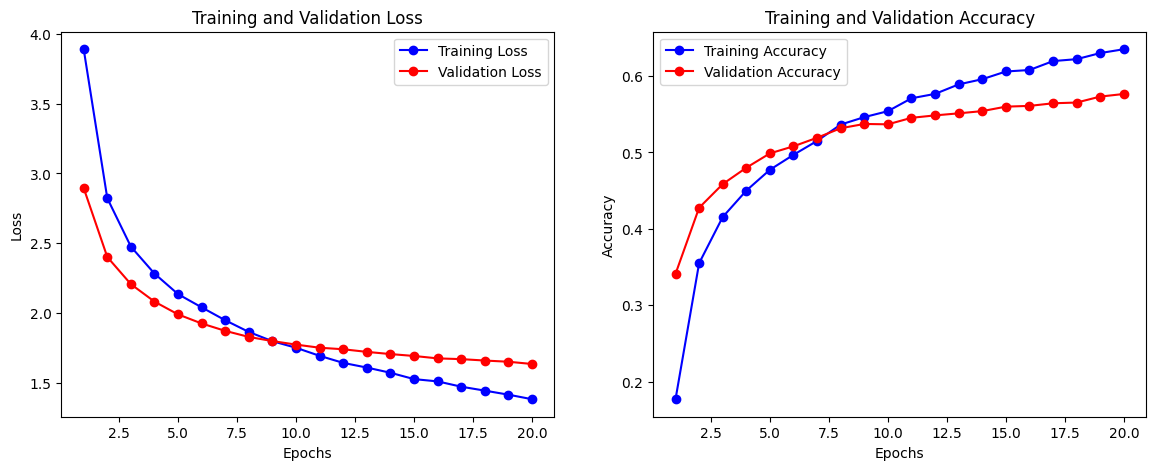

In [7]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    """
    Plots the training and validation accuracy and loss from a Keras History object.
    
    Parameters:
    -----------
    history : keras.callbacks.History
        The History object returned by model.fit().
    """
    # Retrieve metrics from the history object
    acc      = history.history.get('accuracy', [])
    val_acc  = history.history.get('val_accuracy', [])
    loss     = history.history.get('loss', [])
    val_loss = history.history.get('val_loss', [])
    
    epochs = range(1, len(loss) + 1)
    
    # Create subplots for loss and accuracy
    plt.figure(figsize=(14, 5))
    
    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, 'bo-', label='Training Loss')
    if val_loss:
        plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, acc, 'bo-', label='Training Accuracy')
    if val_acc:
        plt.plot(epochs, val_acc, 'ro-', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.show()

# Example usage:
plot_training_history(history)


In [15]:
test_ds = tools.tensorflow_dataset(
    test_df,
    batch_size=128,
    image_size=(224, 224),
)

test_ds_sp = test_ds.map(lambda image, labels: (image, labels['species']))

In [16]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

all_true = []
all_pred = []
all_conf = []

#sp_labels = sorted(df_eviota['species'].unique())

for batch in test_ds_sp:
    images, labels = batch
    
    true = tf.argmax(labels, axis=1).numpy()
    pred = model.predict(images, verbose=0)
    
    pred = tf.argmax(pred, axis=1)
    #conf = tf.reduce_max(pred, axis=1)
    
    all_true.extend(true)
    all_pred.extend(pred)
    #all_conf.extend(conf)

2025-02-08 00:47:18.084735: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
